# COGS 108 - Final Project 

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that PIDs will be scraped from the public submission, but student names will be included.)

* [X] YES - make available
* [  ] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Kyle Huang
- Derek Tse
- Zhaoge Ouyang
- Cary Wang

# Group Members IDs

- A15747306
- A14136586
- A15405768
- A15071719

# Research Question

Can a game's genre, critic score, and gaming platform predict the popularity of a game(based on the # of sales)?

## Background and Prior Work

This question is interesting because:
We will be able to see the current trends in gaming.
When a game is released by a company, the critic score, the company its made by, and the genre can predict how well the game does in the market. These all influence the popularity of a game. So according to these variables, we want to predict how popular a game is and if it is worth playing. Recently some popular games such as among us and Genshin Impact have skyrocketed in popularity and sales, so we want to investigate what exactly makes games like this popular so fast.
References (include links):
- 1)https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.549.6080&rep=rep1&type=pdf
- 2)https://www.kaggle.com/gulsahdemiryurek/video-game-sales-exploratory-data-analysis

# Hypothesis


Our hypothesis is that games that fall into the adventure and strategy genres tend to have the highest sales (and therefore popularity) due to games in the two genres having more sales, higher critic scores, and a stronger focus on a single game console than games from other genres. Addendum: In other words, at least game genre and critic score should have an effect on the popularity of a game. When we think about most popular console game series such as Pokemon or Legend of Zelda, these game series both fall into the adventure genre, and these are also usually most highly acclaimed by critics and users alike.

# Dataset(s)

- Dataset Name: Video Game Sales
- Link to the dataset: https://www.kaggle.com/gregorut/videogamesales
- Number of observations: 16598

According to the dataset description, this dataset encompasses sales data for video games that had greater than 100,000 copies sold. The dataset gives us sales data for US, Europe, Japan, and then rest of the world (in millions). The dataset is sorted by total sales, in decreasing order.

# Setup

Let's begin by importing some packages for analysis.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

Let's import the dataset listed for the analysis.

In [3]:
vgsales = pd.read_csv('vgsales.csv')
metacritic = pd.read_csv('metacritic_games.csv')

To make sure that our data is imported properly:

In [4]:
vgsales.shape

(16598, 11)

In [5]:
vgsales.head()

,Rank,Name,Platform,Year,...,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,...,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,...,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,...,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,...,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,...,8.89,10.22,1.00,31.37


In [6]:
vgsales.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')

In [7]:
metacritic.shape

(5699, 15)

In [8]:
metacritic.head()

,game,platform,developer,genre,...,neutral_users,negative_users,metascore,user_score
0,Portal 2,PC,Valve Software,Action,...,107,19,95,90
1,The Elder Scrolls V: Skyrim,PC,Bethesda Game Studios,Role-Playing,...,322,451,94,82
2,The Legend of Zelda: Ocarina of Time 3D,3DS,GREZZO,Miscellaneous,...,20,5,94,90
3,Batman: Arkham City,PC,Rocksteady Studios,Action Adventure,...,34,27,91,87
4,Super Mario 3D Land,3DS,Nintendo,Action,...,39,11,90,84


In [9]:
metacritic.columns

Index(['game', 'platform', 'developer', 'genre', 'number_players', 'rating',
       'release_date', 'positive_critics', 'neutral_critics',
       'negative_critics', 'positive_users', 'neutral_users', 'negative_users',
       'metascore', 'user_score'],
      dtype='object')

Merge the critic scores with the sales data.

In [10]:
vgsales = metacritic.merge(vgsales, left_on='game', right_on='Name')

# Data Cleaning

## Picking out the relevant columns:

In [11]:
vgsales.columns

Index(['game', 'platform', 'developer', 'genre', 'number_players', 'rating',
       'release_date', 'positive_critics', 'neutral_critics',
       'negative_critics', 'positive_users', 'neutral_users', 'negative_users',
       'metascore', 'user_score', 'Rank', 'Name', 'Platform', 'Year', 'Genre',
       'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales',
       'Global_Sales'],
      dtype='object')

The column labels are not clear, so we'll rename some of them. In the Kaggle page, sales are in units of millions. We will also not make use of the release year and the rank (we'll create our own ranks). Since we are only interested in the critic and user scores from the Metacritic data, we will not use the rest. We might not need name, but we'll keep it for now.

In [12]:
vgsales = vgsales.drop(['Year', 'Rank', 'Publisher', 'release_date', 'platform', 'genre', 'rating'], axis=1)
vgsales = vgsales.rename(columns=str.lower)
vgsales = vgsales.rename(columns={'na_sales' : 'na_sales_million', 'eu_sales': 'eu_sales_million', 'jp_sales': 'jp_sales_million', 'other_sales': 'other_sales_million', 'global_sales': 'global_sales_million'})

Let's take a look at the platforms available. We won't use all of them for analysis (namely, we only use platforms that are released 2005 or later). We will store the platforms we will look at in the variable `platforms`.

In [13]:
vgsales['platform'].unique()

array(['X360', 'PS3', 'PC', 'WiiU', '3DS', 'PSP', 'PSV', 'PS4', 'XOne',
       'Wii', 'DS', 'PS2', 'GEN', 'XB', 'GC', 'PS', 'SAT', 'SNES', '2600',
       'GBA', 'N64'], dtype=object)

In [14]:
platforms = ['PC', 'DS', 'Wii', 'WiiU', '3DS', 'PS3', 'PS4', 'PSV', 'XB', 'X360', 'XOne']

We'll drop the rest.

In [15]:
vgsales['platform'] = vgsales['platform'].apply(lambda x: x if x in platforms else np.nan)
vgsales.dropna(subset=['platform'], inplace=True)

In [16]:
vgsales['platform'].unique()

array(['X360', 'PS3', 'PC', 'WiiU', '3DS', 'PSV', 'PS4', 'XOne', 'Wii',
       'DS', 'XB'], dtype=object)

Finally, let's drop rows that are missing one or more data point for sales data.

In [17]:
vgsales = vgsales.dropna(subset=['eu_sales_million', 'jp_sales_million', 'na_sales_million', 'other_sales_million', 'global_sales_million'])

Let's see how many rows are we left with, after cleaning:

In [18]:
vgsales.shape

(2509, 19)

## Making new data:

In addition to picking the relevant columns, we would like to prepare data for analysis. We'll start with creating a one-hot encoding matrix:

In [19]:
genere_unique = vgsales['genre'].unique()

In [20]:
genre_encode = pd.get_dummies(vgsales['genre'])
genre_encode

,Action,Adventure,Fighting,Misc,...,Shooter,Simulation,Sports,Strategy
0,0,0,0,0,...,1,0,0,0
1,0,0,0,0,...,1,0,0,0
2,0,0,0,0,...,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2574,0,0,0,1,...,0,0,0,0
2575,0,0,0,0,...,1,0,0,0
2591,1,0,0,0,...,0,0,0,0


Next, we assign a rank relative to sales data. We'll use pandas' `rank` function. The higher the rank value, the better performance it has in sales.

In [42]:
s = vgsales.loc[:, ['genre', 'global_sales_million']]
vgsales['rank'] = s['global_sales_million'].rank()

1245.0

Finally, we will determine that a game is popular if the rank of the game is equal or above a predefined threshold, which we will define to be the median of the ranks.

In [43]:
threshold = vgsales['rank'].median()
vgsales['popular'] = vgsales['rank'].apply(lambda x: 1 if x >= threshold else 0)

This is ready for data analysis.
Note: Some video games are released in multiple platforms. This dataset treats them as different observations.

# Data Analysis & Results

We have total of 9480 observations as shown.

In [22]:
vgsales.shape

(2509, 20)

We will be looking at variables name, platform, genre, and publisher.

In [23]:
#variables = vgsales.loc[:, ['rank', 'name', 'platform', 'release_year', 'genre', 'publisher']]
#variables = variables.dropna(subset=['rank', 'name', 'platform', 'release_year', 'genre', 'publisher'])
#variables

vgsales.columns

In [24]:
sales = vgsales.loc[:, ['genre','na_sales_million', 'eu_sales_million', 'jp_sales_million','other_sales_million', 'global_sales_million']]
sales

,genre,na_sales_million,eu_sales_million,jp_sales_million,other_sales_million,global_sales_million
0,Shooter,1.41,0.51,0.01,0.17,2.10
1,Shooter,0.83,0.63,0.02,0.25,1.74
2,Shooter,0.33,0.32,0.00,0.11,0.76
...,...,...,...,...,...,...
2574,Misc,0.48,0.68,0.33,0.16,1.65
2575,Shooter,0.07,0.01,0.02,0.01,0.10
2591,Action,0.09,0.02,0.00,0.00,0.12


The max sale has a value that is far above the average sale across all sales columns, making the max sale an outlier as shown below.

In [25]:
sales.describe()

,na_sales_million,eu_sales_million,jp_sales_million,other_sales_million,global_sales_million
count,2509.00,2509.00,2509.00,2509.00,2509.00
mean,0.38,0.36,0.05,0.11,0.89
std,0.80,0.76,0.18,0.26,1.77
...,...,...,...,...,...
50%,0.12,0.12,0.00,0.04,0.32
75%,0.38,0.35,0.03,0.10,0.92
max,9.63,9.27,4.36,4.14,21.40


In [26]:
na_sales_million = sales['na_sales_million']
na_sales_million = na_sales_million[na_sales_million < 40]
na_sales_million

0       1.41
1       0.83
2       0.33
        ... 
2574    0.48
2575    0.07
2591    0.09
Name: na_sales_million, Length: 2509, dtype: float64

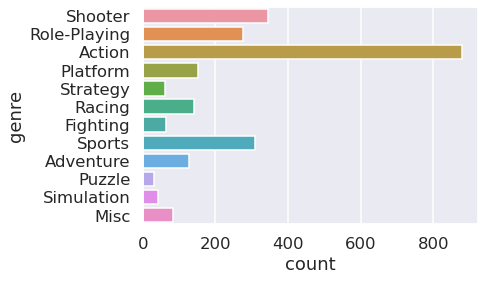

In [27]:
sns.countplot(y ='genre', data = vgsales)

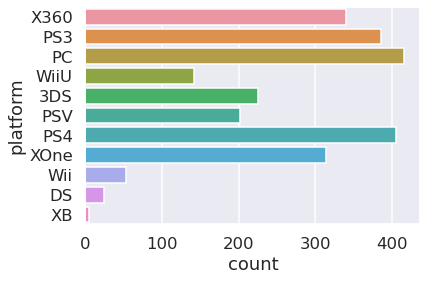

In [28]:
sns.countplot(y ='platform', data = vgsales)

From this graph we can see that most games are sold in North America, with the most made genre being action videogames.

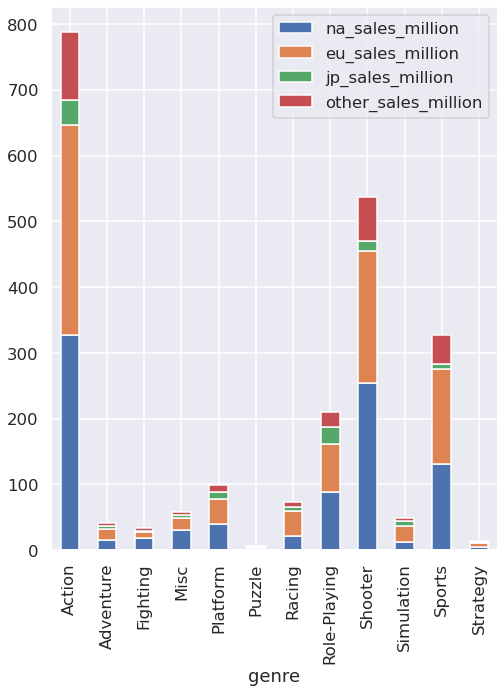

In [29]:
salesD = sales.groupby(['genre']).sum()
region = sales['genre'].unique()
salesD = salesD.drop(columns = ['global_sales_million'])
ax = salesD.plot.bar(stacked=True)
fig = plt.gcf()
fig.set_size_inches(8,10)

NA sales graph looks very simliar to the global sales graph since most of the sales are from here.

Text(0.5, 1.0, 'Videogame Sales by Genre North America 2000-2016')

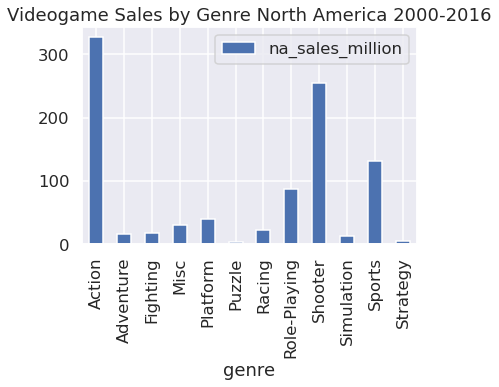

In [30]:
salesD = sales.groupby(['genre']).sum()
na = salesD.plot.bar(y = ['na_sales_million'])
plt.title('Videogame Sales by Genre North America 2000-2016')

Though Japan makes up a smaller portion of videogame sales globally, role playing games have the highest sales, rather than shooter, sports, and action games which have higher sales in other regions.

Text(0.5, 1.0, 'Videogame Sales by Genre Japan 2000-2016')

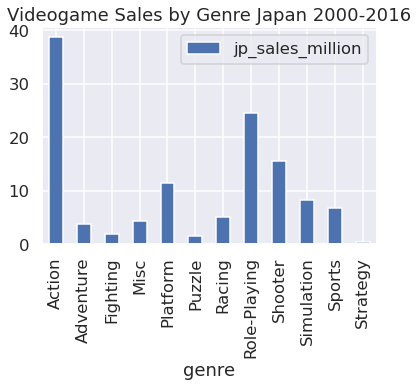

In [31]:
jp = salesD.plot.bar(y = ['jp_sales_million'])
plt.title('Videogame Sales by Genre Japan 2000-2016')

Sales in EU are very similar to NA, and also make up a decent portion of the total sales.

Text(0.5, 1.0, 'Videogame Sales by Genre Europe 2000-2016')

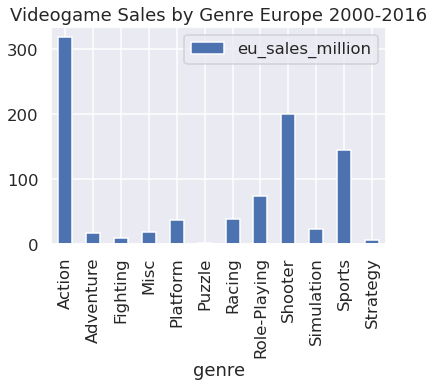

In [32]:
eu = salesD.plot.bar(y = ['eu_sales_million'])
plt.title('Videogame Sales by Genre Europe 2000-2016')

In [33]:
#salesD = vgsales.sort_values(by='release_year')
#sns.scatterplot(data=salesD, x="rank", y="jp_sales_million")
#fig = plt.gcf()
#fig.set_size_inches(8,10)
#salesD

According to the graph, critic scores seem to be correlated with user scores, indicating that user score is correlated with metascore. User score is the average score given by users for a game, and metascore is the average critic score given by critics from metacritic.com.

Text(0.5, 1.0, 'User Score vs Metascore')

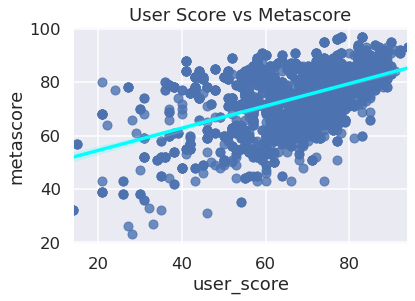

In [34]:
sns.regplot(data=vgsales, x="user_score", y="metascore",line_kws={"color": "cyan"})
plt.title('User Score vs Metascore')

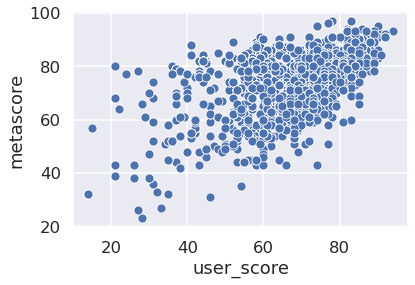

In [35]:
sns.scatterplot(data=vgsales, x="user_score", y="metascore")

However, if we compare user score to total sales, there is little correlation. Some games that were given a really high user score did not have as much success as those games that have a lower score, and vice versa. The highest grossing games in this set have a score of about 82. People seem to still buy games even if they are rated poorly, and there are quit a few games that users gave high scores to, that did not sell so well.

Text(0.5, 1.0, 'User Score vs Metascore')

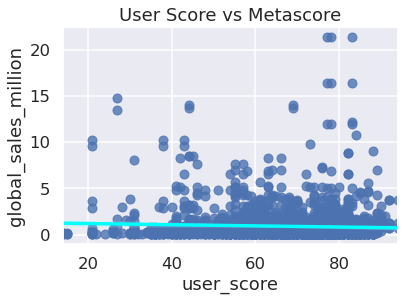

In [36]:
sns.regplot(data=vgsales, x="user_score", y="global_sales_million",line_kws={"color": "cyan"})
plt.title('User Score vs Metascore')

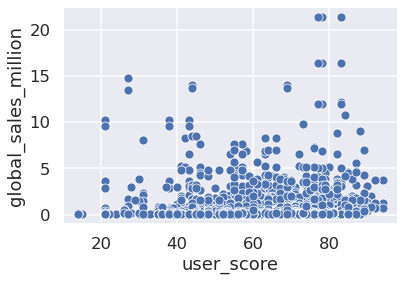

In [37]:
sns.scatterplot(data=vgsales, x="user_score", y="global_sales_million")

In this case, there is a little more correlation between critic score and sales than the previous graph, which may suggest that critic score can influence how well a game sells.

Text(0.5, 1.0, 'Metascore vs Sales')

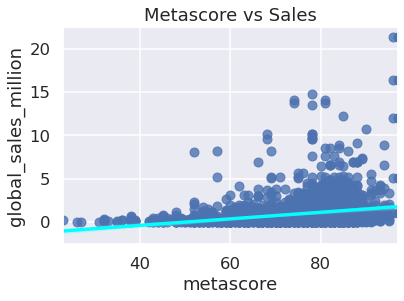

In [38]:
sns.regplot(data=vgsales, x="metascore", y="global_sales_million",line_kws={"color": "cyan"})
plt.title('Metascore vs Sales')

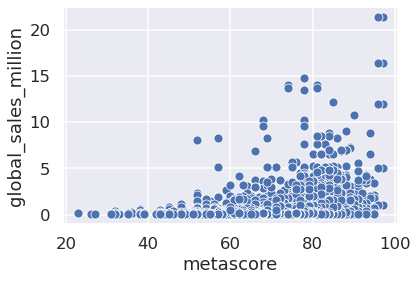

In [39]:
sns.scatterplot(data=vgsales, x="metascore", y="global_sales_million")

In [40]:
s = sales.loc[:, ['genre', 'global_sales_million']]
s['rank'] = s['global_sales_million'].rank()

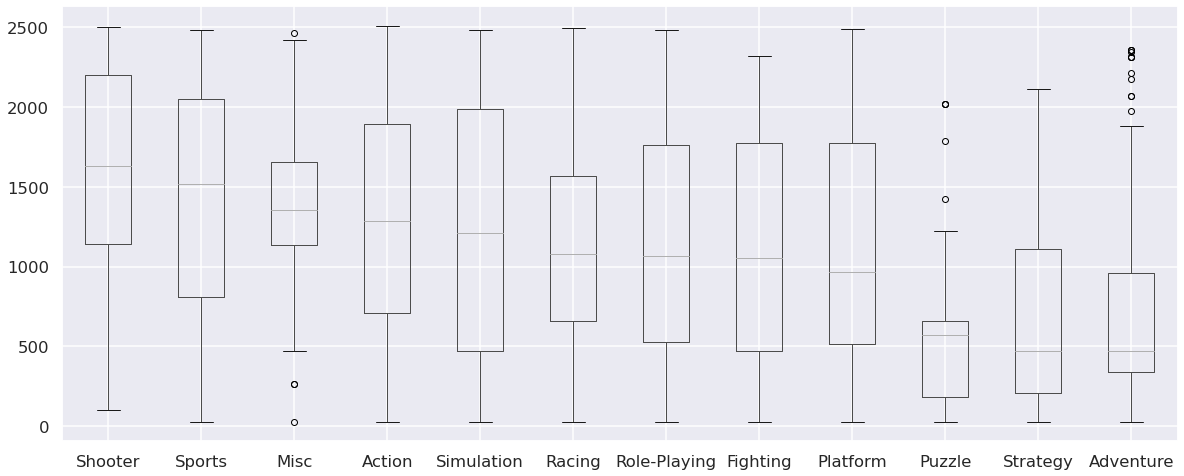

In [41]:
group = s.groupby('genre')
df2 = pd.DataFrame({col:vals['rank'] for col,vals in group})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
df2 = df2[meds.index]
df2.boxplot(figsize=(20,8))
plt.show()

In the above boxplot, the higher the rank value on the y-axis, the better the sales. The above boxplot suggests that a shooter game tends to be higher ranked in terms of sales. The boxplot also shows several outliers in genres such as adventure. This suggests that while there are some adventure games that are highly ranked in sales, the genre as a whole does not do well in sales. However, because the medians of these genres are dissimilar, the boxplot suggests that genre does affect the sales of a game.

# Analysis

We proceed to build a model based on `user_score`, `metascore`, and `genre`. We are trying to predict `popular`, which is defined by the ranking of `global_sales_million`.

# Ethics & Privacy

There are no PII involved with the data(as we are strictly dealing with public data in the gaming industry). The data used in this project are very close to accurate. Data used in this dataset was scraped from a website called vgchartz.com. This website gets their data from Famitsu, a Japanese videogame magazine, and sales data from NPD, which is a reputable private market research company. The critic score dataset contains data scraped from metacritic.com, which are the critic scores for each game directly from their website.
The data we used is public, however the analysis would show how the large companies have games that are more popular, and could benefit the sales of those companies. Because of this, we decided to leave out the names of the developers to not show any bias or provide any benefit.

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

Overview: Everyone

Data Cleaning: Derek, Gary

EDA: Everyone

Analysis: Kyle, Derek

Conclusion & Discussion:

Ethics & Privacy: Kyle